In [1]:
!pip install image-invisible-watermarker
!pip install invisible-watermark
!pip install diffusers transformers accelerate torch pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import cv2
import numpy as np
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch

/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
img = cv2.imread("/content/drive/MyDrive/datasets/ai_sec/image1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

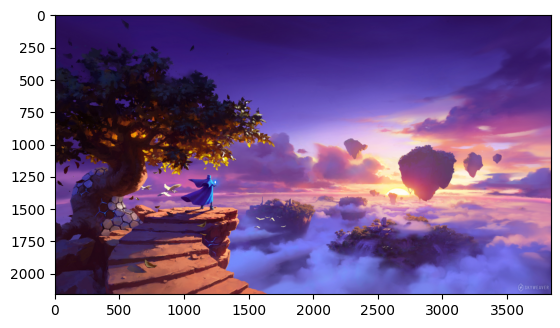

In [5]:
plt.imshow(img)

In [6]:
def rotate(img):
    rotation_degrees = 10

    h, w = img.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, rotation_degrees, 1.0)

    cos = abs(M[0, 0])
    sin = abs(M[0, 1])

    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    rotated = cv2.warpAffine(
        img, M, (new_w, new_h), flags=cv2.INTER_CUBIC
    )

    return rotated


def add_noise(img):
    noise_std = 10

    arr = img.astype(np.float32)
    noise = np.random.normal(0, noise_std, arr.shape)

    arr = arr + noise
    arr = np.clip(arr, 0, 255).astype(np.uint8)

    return arr


def add_blur(img):
    return cv2.GaussianBlur(img, (7, 7), 0)

def full_modify_image(img):
    img = rotate(img)
    img = add_noise(img)
    img = add_blur(img)
    return img

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if device=="cuda" else torch.float32
).to(device)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

def cv2_diffusion_edit(cv2_img, noise_strength=0.1):

    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (512, 512))

    img_tensor = torch.from_numpy(img).float() / 255.0

    img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        latent_dist = pipe.vae.encode(img_tensor).latent_dist
        latents = latent_dist.sample() * 0.18215

    latents = latents + torch.randn_like(latents) * noise_strength

    with torch.no_grad():
        recon = pipe.vae.decode(latents / 0.18215).sample
        recon = (recon / 2 + 0.5).clamp(0, 1)  # normalize to [0,1]
        recon = recon.cpu().permute(0, 2, 3, 1).numpy()[0]  # BCHW -> HWC
        recon = (recon * 255).astype(np.uint8)
        recon = cv2.cvtColor(recon, cv2.COLOR_RGB2BGR)
        recon = cv2.resize(recon, (cv2_img.shape[1], cv2_img.shape[0]))
    return recon

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [27]:
rotated = rotate(img)
noised = add_noise(img)
blurred = add_blur(img)
full_mod = full_modify_image(img)
diffused = cv2_diffusion_edit(img)

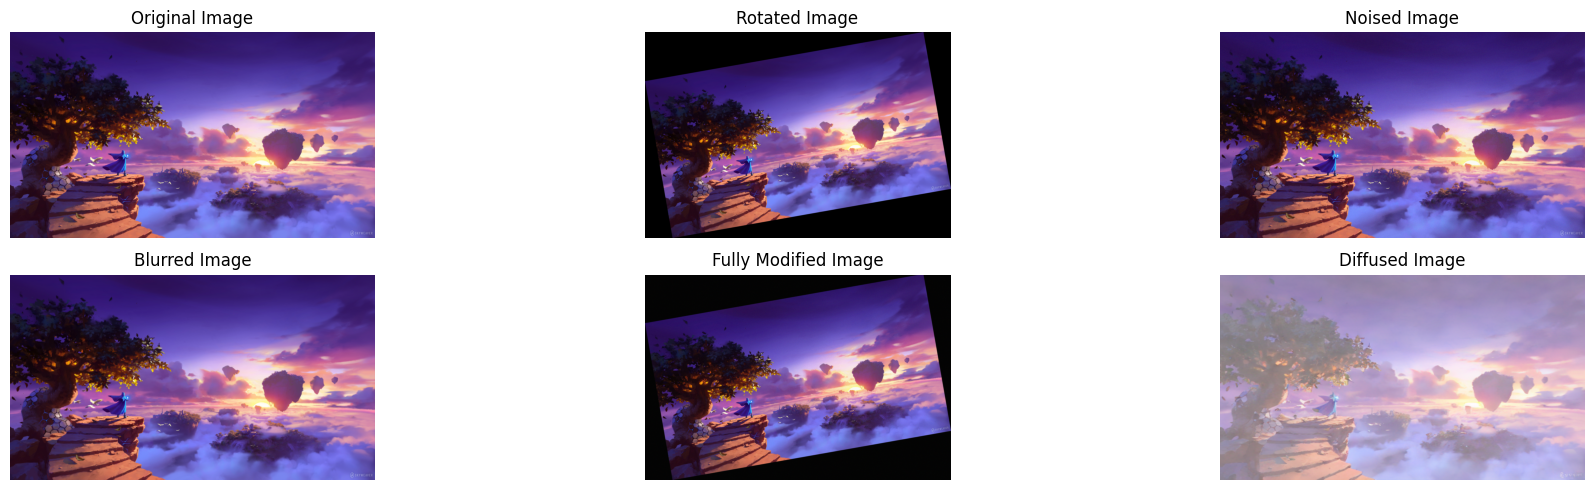

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(20, 5))

axes[0][0].imshow(img)
axes[0][0].set_title('Original Image')
axes[0][0].axis('off')

axes[0][1].imshow(rotated)
axes[0][1].set_title('Rotated Image')
axes[0][1].axis('off')

axes[0][2].imshow(noised)
axes[0][2].set_title('Noised Image')
axes[0][2].axis('off')

axes[1][0].imshow(blurred)
axes[1][0].set_title('Blurred Image')
axes[1][0].axis('off')

axes[1][1].imshow(full_mod)
axes[1][1].set_title('Fully Modified Image')
axes[1][1].axis('off')

axes[1][2].imshow(diffused)
axes[1][2].set_title('Diffused Image')
axes[1][2].axis('off')

plt.tight_layout()
plt.show()

In [36]:
results = []

In [45]:
from image_watermarker import add_watermark_png, check_watermark_png

image_bytes = add_watermark_png("/content/drive/MyDrive/datasets/ai_sec/image2.png", "My Watermark")
if image_bytes:
    with open("/content/drive/MyDrive/datasets/ai_sec/image2_watermarked.png", "wb") as f:
        f.write(image_bytes)

img_with_watermark = cv2.imread("/content/drive/MyDrive/datasets/ai_sec/image2_watermarked.png",cv2.IMREAD_UNCHANGED)

rotated = rotate(img_with_watermark)
noised = add_noise(img_with_watermark)
blurred = add_blur(img_with_watermark)
full_mod = full_modify_image(img_with_watermark)
diffused = cv2_diffusion_edit(img_with_watermark)


cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/rotated.png", rotated)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/noised.png", noised)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/blurred.png", blurred)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/full_mod.png", full_mod)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/diffused.png", diffused)

res_base_img = check_watermark_png("/content/drive/MyDrive/datasets/ai_sec/image2.png", "My Watermark")
res_water_marked = check_watermark_png("/content/drive/MyDrive/datasets/ai_sec/image2_watermarked.png", "My Watermark")
res_rotated = check_watermark_png(f"/content/drive/MyDrive/datasets/ai_sec/rotated.png", "My Watermark")
res_noised = check_watermark_png(f"/content/drive/MyDrive/datasets/ai_sec/noised.png", "My Watermark")
res_blurred = check_watermark_png(f"/content/drive/MyDrive/datasets/ai_sec/blurred.png", "My Watermark")
res_full_mod = check_watermark_png(f"/content/drive/MyDrive/datasets/ai_sec/full_mod.png", "My Watermark")
res_diffused = check_watermark_png(f"/content/drive/MyDrive/datasets/ai_sec/diffused.png", "My Watermark")



print("IsDetected base_img:", res_base_img[0])
print("IsDetected water_marked:", res_water_marked[0])
print("IsDetected rotated:", res_rotated[0])
print("IsDetected noised:", res_noised[0])
print("IsDetected blurred:", res_blurred[0])
print("IsDetected full_mod:", res_full_mod[0])
print("IsDetected diffused:", res_diffused[0])

results.append({"image_watermarker":[res_base_img[0],res_water_marked[0],res_rotated[0],res_noised[0],res_blurred[0],res_full_mod[0],res_diffused[0]]})


IsDetected base_img: False
IsDetected water_marked: True
IsDetected rotated: False
IsDetected noised: False
IsDetected blurred: False
IsDetected full_mod: False
IsDetected diffused: False


In [46]:
from scipy.fftpack import dct, idct
import cv2
import numpy as np

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def dct_embed(image_path, output_path):
    img = cv2.imread(image_path, 0)
    img = img.astype(float)

    block = img[:8, :8]
    dct_block = dct2(block)

    dct_block[4, 4] += 50
    img[:8, :8] = idct2(dct_block)

    cv2.imwrite(output_path, np.clip(img, 0, 255))

def dct_detect(image_path):
    img = cv2.imread(image_path, 0).astype(float)
    block = img[:8, :8]
    dct_block = dct2(block)

    return dct_block[4, 4] > 20


dct_embed("/content/drive/MyDrive/datasets/ai_sec/image1.jpg", "/content/drive/MyDrive/datasets/ai_sec/image1_dct.jpg")


img_with_watermark = cv2.imread("/content/drive/MyDrive/datasets/ai_sec/image1_dct.jpg")

rotated = rotate(img_with_watermark)
noised = add_noise(img_with_watermark)
blurred = add_blur(img_with_watermark)
full_mod = full_modify_image(img_with_watermark)
diffused = cv2_diffusion_edit(img_with_watermark)


cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/rotated.jpg", rotated)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/noised.jpg", noised)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/blurred.jpg", blurred)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/full_mod.jpg", full_mod)
cv2.imwrite(f"/content/drive/MyDrive/datasets/ai_sec/diffused.jpg", diffused)

res_base_img = dct_detect("/content/drive/MyDrive/datasets/ai_sec/image1.jpg")
res_water_marked = dct_detect("/content/drive/MyDrive/datasets/ai_sec/image1_dct.jpg")
res_rotated = dct_detect(f"/content/drive/MyDrive/datasets/ai_sec/rotated.jpg")
res_noised = dct_detect(f"/content/drive/MyDrive/datasets/ai_sec/noised.jpg")
res_blurred = dct_detect(f"/content/drive/MyDrive/datasets/ai_sec/blurred.jpg")
res_full_mod = dct_detect(f"/content/drive/MyDrive/datasets/ai_sec/full_mod.jpg")
res_diffused = dct_detect(f"/content/drive/MyDrive/datasets/ai_sec/diffused.jpg")



print("IsDetected base_img:", res_base_img)
print("IsDetected water_marked:", res_water_marked)
print("IsDetected rotated:", res_rotated)
print("IsDetected noised:", res_noised)
print("IsDetected blurred:", res_blurred)
print("IsDetected full_mod:", res_full_mod)
print("IsDetected diffused:", res_diffused)

results.append({"dct":[res_base_img,res_water_marked,res_rotated,res_noised,res_blurred,res_full_mod,res_diffused]})

IsDetected base_img: False
IsDetected water_marked: True
IsDetected rotated: False
IsDetected noised: True
IsDetected blurred: False
IsDetected full_mod: False
IsDetected diffused: False


In [49]:
results

[{'image_watermarker': [False, True, False, False, False, False, False]},
 {'dct': [np.False_,
   np.True_,
   np.False_,
   np.True_,
   np.False_,
   np.False_,
   np.False_]}]

In [66]:
import pywt

def dwt_embed(img):

    coeffs = pywt.dwt2(img, 'haar')

    LL, (LH, HL, HH) = coeffs
    HH += 10

    watermarked = pywt.idwt2((LL, (LH, HL, HH)), 'haar')
    return watermarked

def dwt_detect(img):
    coeffs = pywt.dwt2(img, 'haar')
    _, (_, _, HH) = coeffs

    return np.mean(HH) > 5

img = cv2.imread("/content/drive/MyDrive/datasets/ai_sec/image1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_with_watermark = dwt_embed(img).astype(np.uint8)


rotated = rotate(img_with_watermark)
noised = add_noise(img_with_watermark)
blurred = add_blur(img_with_watermark)
full_mod = full_modify_image(img_with_watermark)
diffused = cv2_diffusion_edit(img_with_watermark)

res_base_img = dwt_detect(img)
res_water_marked = dwt_detect(img_with_watermark)
res_rotated = dwt_detect(rotated)
res_noised = dwt_detect(noised)
res_blurred = dwt_detect(blurred)
res_full_mod = dwt_detect(full_mod)
res_diffused = dwt_detect(diffused)

print("IsDetected base_img:", res_base_img)
print("IsDetected water_marked:", res_water_marked)
print("IsDetected rotated:", res_rotated)
print("IsDetected noised:", res_noised)
print("IsDetected blurred:", res_blurred)
print("IsDetected full_mod:", res_full_mod)
print("IsDetected diffused:", res_diffused)


results.append({"dwt":[res_base_img,res_water_marked,res_rotated,res_noised,res_blurred,res_full_mod,res_diffused]})

IsDetected base_img: False
IsDetected water_marked: True
IsDetected rotated: False
IsDetected noised: True
IsDetected blurred: False
IsDetected full_mod: False
IsDetected diffused: False


In [64]:
img.shape

(2160, 3840, 3)

In [59]:
from imwatermark import WatermarkEncoder,WatermarkDecoder

img = cv2.imread("/content/drive/MyDrive/datasets/ai_sec/image1.jpg")

wm = np.array([1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0], dtype=np.uint8)

encoder = WatermarkEncoder()
encoder.set_watermark('bits', wm)

img_with_watermark = encoder.encode(img, 'dwtDct')

rotated = rotate(img_with_watermark)
noised = add_noise(img_with_watermark)
blurred = add_blur(img_with_watermark)
full_mod = full_modify_image(img_with_watermark)
#diffused = cv2_diffusion_edit(img_with_watermark)

decoder = WatermarkDecoder('bits', 12)

res_base_img = decoder.decode(img,'dwtDct')
res_water_marked = decoder.decode(img_with_watermark,'dwtDct')
res_rotated = decoder.decode(rotated,'dwtDct')
res_noised = decoder.decode(noised,'dwtDct')
res_blurred = decoder.decode(blurred,'dwtDct')
res_full_mod = decoder.decode(full_mod,'dwtDct')
#res_diffused = WatermarkDecoder(diffused,'dwtDct')

print("IsDetected base_img:", res_base_img)
print("IsDetected water_marked:", res_water_marked)
print("IsDetected rotated:", res_rotated)
print("IsDetected noised:", res_noised)
print("IsDetected blurred:", res_blurred)
print("IsDetected full_mod:", res_full_mod)
#print("IsDetected diffused:", res_diffused)


IsDetected base_img: [ True  True  True  True  True  True  True  True  True  True  True  True]
IsDetected water_marked: [ True  True  True  True False  True  True False  True  True False  True]
IsDetected rotated: [False False False False False False False False False False False False]
IsDetected noised: [ True False  True  True False  True False False False False False False]
IsDetected blurred: [ True False  True  True False  True False False False False False False]
IsDetected full_mod: [False False False False False False False False False False False False]


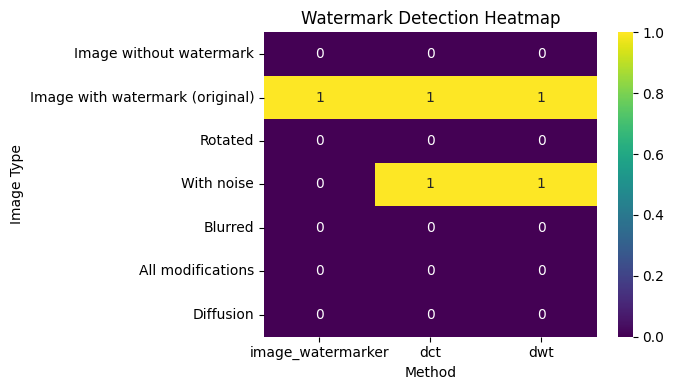

In [71]:
import pandas as pd
import seaborn as sns
y_labels = [
    "Image without watermark",
    "Image with watermark (original)",
    "Rotated",
    "With noise",
    "Blurred",
    "All modifications",
    "Diffusion"
]


df = pd.DataFrame({k: v for d in results for k, v in d.items()})


df = df.astype(int)

plt.figure(figsize=(7, 4))
ax = sns.heatmap(
    df,
    cmap="viridis",
    cbar=True,
    annot=True,
    fmt="d",
    yticklabels=y_labels
)

plt.xlabel("Method")
plt.ylabel("Image Type")
plt.title("Watermark Detection Heatmap")
plt.tight_layout()
plt.show()